<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/12_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнеее задание: Июльский курс (2020). Pro. Занятие 12
##Сегментация изображений
## Верхошинская Катерина Викторовна

## **LIGHT**

### Задание:

1. Сделайте выделение классов по отдельности
* Пола
* Того, что за окном
* Людей
* Батарей
* Лампочек
2. Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке
3. Проверьте различные batch_size
4. Проверьте различные активационные функции
5. Напишите ваши выводы


In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 6 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/Colab Notebooks/Базы/Сегментация/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки
test_images = [] # Создаем пустой список для хранений оригинльных изображений тестовой выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загржуена. Время загрузки: 236.69c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 11.77c
Количество изображений:  50


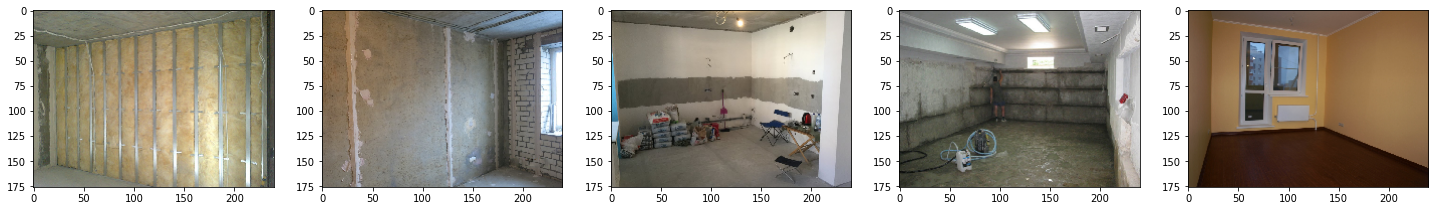

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_images) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загржуена. Время загрузки: 243.22c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 13.16c
Количество изображений:  50


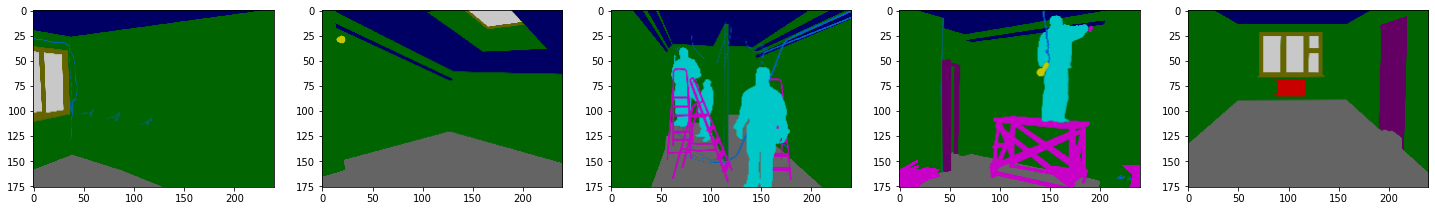

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_segments) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

### Выделим 5 классов(Пол, То что за окном, Люди, Батареи, Лампочеки), как указано в задании, а остальное будет выделятся одним цветом.

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
  index=-1
  if   (149>=color[0]>51)   and(149>=color[1]>=51)  and(149>=color[2]>=51)  : index=0 # пол
  elif (49>=color[0]>=0)    and(49>=color[1]>=0)    and(149>=color[2]>=51)  : index=1 # то, что за окном
  elif (49>=color[0]>=0)    and(149>=color[1]>=51)  and(49>=color[2]>=0)    : index=2 # батарея
  elif (149>=color[0]>=51)  and(49>=color[1]>=0)    and(49>=color[2]>=0)    : index=3 # люди
  elif (49>=color[0]>=0)    and(149>=color[1]>=51)  and(149>=color[2]>=51)    : index=4 # лампочки
  else: index=5
  return index  

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if   index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # то, что за окном
  elif index == 2: color = [0, 100, 0]  # батарея
  elif index == 3: color = [100, 0, 0]  # люди
  elif index == 4: color = [0, 100, 100]  # лампочки
  elif index == 5: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1132.31 c


In [ ]:
np.save('drive/My Drive/Segment/X_train', xTrain)
np.save('drive/My Drive/Segment/Y_train', yTrain)
np.save('drive/My Drive/Segment/X_val', xVal)

In [ ]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  59.73 c


In [ ]:
np.save('drive/My Drive/Segment/Y_val', yVal)

In [ ]:
yTrain.shape

(900, 176, 240, 6)

In [ ]:
xTrain = np.load('drive/My Drive/Segment/X_train.npy')
yTrain = np.load('drive/My Drive/Segment/Y_train.npy')
xVal = np.load('drive/My Drive/Segment/X_val.npy')
yVal = np.load('drive/My Drive/Segment/Y_val.npy')

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 5):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 5)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
'''
  Функция создания сети "Расширенная U-net"
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes = 6, input_shape= (352, 480, 3), activation = 'relu'):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM3.fit(xTrain, yTrain, epochs=200, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/200
57/57 [==============================] - 22s 391ms/step - loss: 1.2032 - dice_coef: 0.4026 - val_loss: 13.1471 - val_dice_coef: 0.1455
Epoch 2/200
57/57 [==============================] - 20s 353ms/step - loss: 0.9104 - dice_coef: 0.5194 - val_loss: 10.3900 - val_dice_coef: 0.2836
Epoch 3/200
57/57 [==============================] - 20s 353ms/step - loss: 0.8359 - dice_coef: 0.5584 - val_loss: 5.8254 - val_dice_coef: 0.3270
Epoch 4/200
57/57 [==============================] - 20s 353ms/step - loss: 0.7665 - dice_coef: 0.5935 - val_loss: 4.2494 - val_dice_coef: 0.4691
Epoch 5/200
57/57 [==============================] - 20s 353ms/step - loss: 0.7492 - dice_coef: 0.6086 - val_loss: 3.0812 - val_dice_coef: 0.4597
Epoch 6/200
57/57 [==============================] - 20s 353ms/step - loss: 0.7063 - dice_coef: 0.6304 - val_loss: 2.2612 - val_dice_coef: 0.5100
Epoch 7/200
57/57 [==============================] - 20s 353ms/step - loss: 0.6885 - dice_coef: 0.6418 - val_loss: 2.1736 

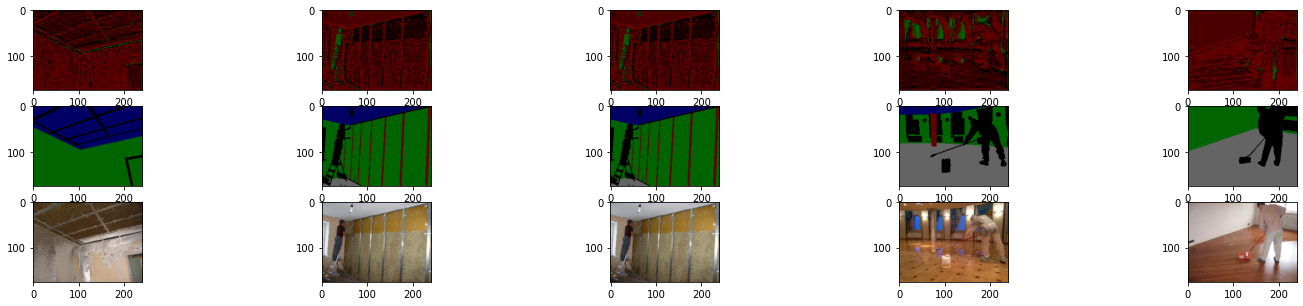

In [ ]:
processImage(modelM3, 5, num_classes)

### **Попробуем изменить архитектуру**

In [ ]:
'''
  Функция создания сети "Расширенная U-net"
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask_my(num_classes = 6, input_shape= (352, 480, 3), activation = 'relu'):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(128, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(256, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x) # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(256, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(512, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(512, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(1024, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(1024, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                          # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

In [ ]:
modelM3 = unetWithMask_my(num_classes, (img_width, img_height,3))
history = modelM3.fit(xTrain, yTrain, epochs=100, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/100
57/57 [==============================] - 61s 1s/step - loss: 1.2578 - dice_coef: 0.3855 - val_loss: 13.3507 - val_dice_coef: 0.1516
Epoch 2/100
57/57 [==============================] - 58s 1s/step - loss: 1.1142 - dice_coef: 0.4287 - val_loss: 13.1229 - val_dice_coef: 0.1408
Epoch 3/100
57/57 [==============================] - 58s 1s/step - loss: 0.9698 - dice_coef: 0.4990 - val_loss: 4.9293 - val_dice_coef: 0.2176
Epoch 4/100
57/57 [==============================] - 58s 1s/step - loss: 0.8537 - dice_coef: 0.5482 - val_loss: 5.8269 - val_dice_coef: 0.5380
Epoch 5/100
57/57 [==============================] - 58s 1s/step - loss: 0.7886 - dice_coef: 0.5847 - val_loss: 4.7651 - val_dice_coef: 0.4460
Epoch 6/100
57/57 [==============================] - 58s 1s/step - loss: 0.7711 - dice_coef: 0.5939 - val_loss: 3.3585 - val_dice_coef: 0.3645
Epoch 7/100
57/57 [==============================] - 58s 1s/step - loss: 0.7376 - dice_coef: 0.6162 - val_loss: 3.6763 - val_dice_coef: 0.23

In [ ]:
modelM3.save_weights('/content/drive/My Drive/modelM_relu.h5')

In [ ]:
modelM_relu = unetWithMask_my(num_classes, (img_width, img_height,3))
modelM_relu.load_weights('/content/drive/My Drive/modelM_relu.h5')

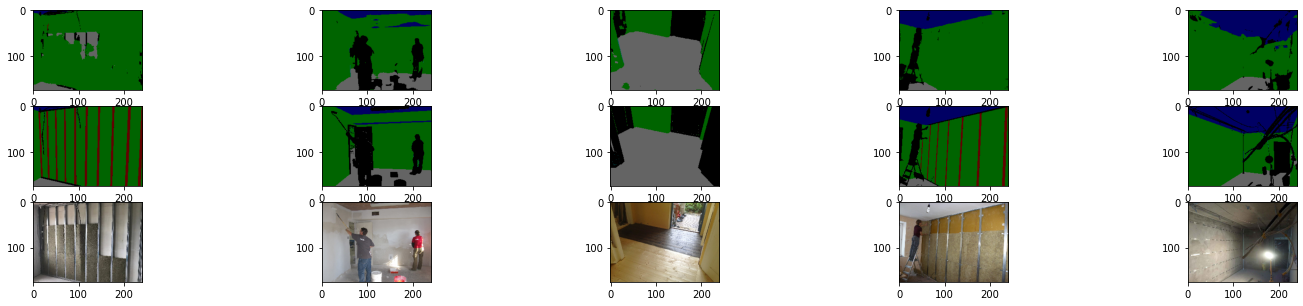

In [ ]:
processImage(modelM_relu, 5, num_classes)

**Итог:** Изменение архитектуры(количество фильтров в сверточных слоях) явно улучшило работоту сети, из чего можно сделать вывод что чем больше фильтров тем лучше. Архитектура PSPNet(в PRO задании) дала очень похожий результ. 

### **Посмотрим на результаты работы сети с разной активационной функцией, на 20 эпохах, batch_size=16**

**активационная функция 'elu'**

In [ ]:
modelM_elu = unetWithMask(num_classes, (img_width, img_height,3), 'elu')
history = modelM_elu.fit(xTrain, yTrain, epochs=20, batch_size=16, validation_data = (xVal, yVal))

Epoch 1/20
57/57 [==============================] - 22s 388ms/step - loss: 1.0536 - dice_coef: 0.4625 - val_loss: 13.8318 - val_dice_coef: 0.1066
Epoch 2/20
57/57 [==============================] - 20s 354ms/step - loss: 0.8287 - dice_coef: 0.5661 - val_loss: 5.3292 - val_dice_coef: 0.4021
Epoch 3/20
57/57 [==============================] - 20s 353ms/step - loss: 0.7662 - dice_coef: 0.6025 - val_loss: 4.4188 - val_dice_coef: 0.4356
Epoch 4/20
57/57 [==============================] - 20s 353ms/step - loss: 0.7369 - dice_coef: 0.6187 - val_loss: 1.8818 - val_dice_coef: 0.4618
Epoch 5/20
57/57 [==============================] - 20s 353ms/step - loss: 0.7111 - dice_coef: 0.6292 - val_loss: 2.4517 - val_dice_coef: 0.4131
Epoch 6/20
57/57 [==============================] - 20s 353ms/step - loss: 0.6884 - dice_coef: 0.6421 - val_loss: 1.5577 - val_dice_coef: 0.4413
Epoch 7/20
57/57 [==============================] - 20s 353ms/step - loss: 0.6554 - dice_coef: 0.6601 - val_loss: 1.5554 - val_di

In [ ]:
modelM_elu.save_weights('/content/drive/My Drive/modelM_elu.h5')

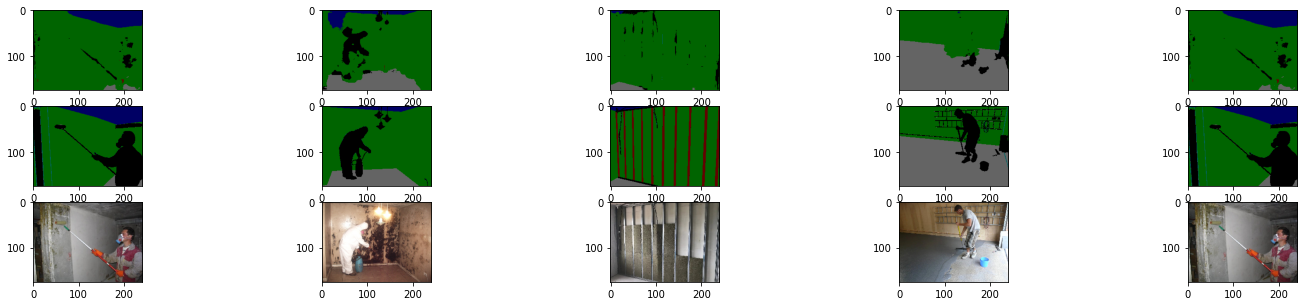

In [ ]:
processImage(modelM_elu, 5, num_classes)

**активационная функция 'softmax'**

In [ ]:
modelM_softmax = unetWithMask(num_classes, (img_width, img_height,3), 'softmax')
history = modelM_softmax.fit(xTrain, yTrain, epochs=20, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/20
57/57 [==============================] - 21s 360ms/step - loss: 1.1785 - dice_coef: 0.4079 - val_loss: 15.3927 - val_dice_coef: 0.0362
Epoch 2/20
57/57 [==============================] - 20s 352ms/step - loss: 0.8980 - dice_coef: 0.5259 - val_loss: 10.4965 - val_dice_coef: 0.2865
Epoch 3/20
57/57 [==============================] - 20s 352ms/step - loss: 0.8100 - dice_coef: 0.5727 - val_loss: 4.6230 - val_dice_coef: 0.4235
Epoch 4/20
57/57 [==============================] - 20s 352ms/step - loss: 0.7758 - dice_coef: 0.5935 - val_loss: 2.6379 - val_dice_coef: 0.5039
Epoch 5/20
57/57 [==============================] - 20s 352ms/step - loss: 0.7363 - dice_coef: 0.6166 - val_loss: 2.7504 - val_dice_coef: 0.4614
Epoch 6/20
57/57 [==============================] - 20s 352ms/step - loss: 0.6951 - dice_coef: 0.6362 - val_loss: 1.6607 - val_dice_coef: 0.4389
Epoch 7/20
57/57 [==============================] - 20s 352ms/step - loss: 0.6964 - dice_coef: 0.6360 - val_loss: 1.5779 - val_d

In [ ]:
modelM_softmax.save_weights('/content/drive/My Drive/modelM_softmax.h5')

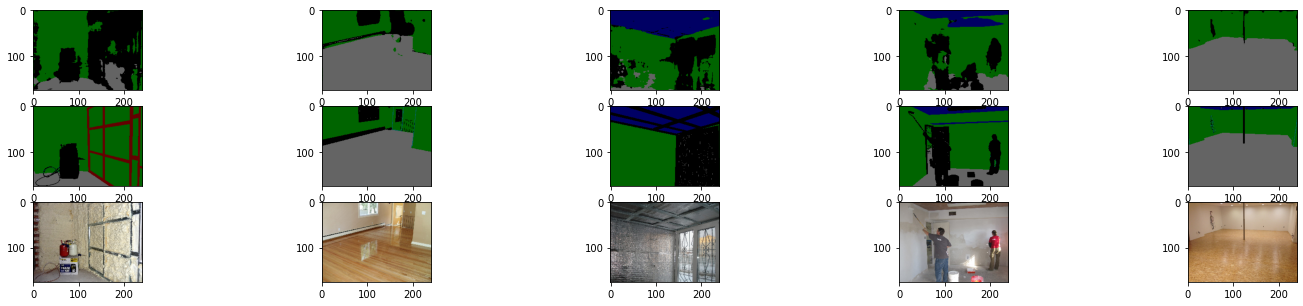

In [ ]:
processImage(modelM_softmax, 5, num_classes)

In [ ]:
modelM_relu = unetWithMask(num_classes, (img_width, img_height,3), 'relu')
history = modelM_relu.fit(xTrain, yTrain, epochs=20, batch_size=16, validation_data = (xVal, yVal)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/20
57/57 [==============================] - 21s 360ms/step - loss: 1.1924 - dice_coef: 0.4030 - val_loss: 9.6070 - val_dice_coef: 0.2921
Epoch 2/20
57/57 [==============================] - 20s 352ms/step - loss: 0.9556 - dice_coef: 0.4987 - val_loss: 12.6321 - val_dice_coef: 0.1636
Epoch 3/20
57/57 [==============================] - 20s 352ms/step - loss: 0.8052 - dice_coef: 0.5788 - val_loss: 9.8130 - val_dice_coef: 0.2285
Epoch 4/20
57/57 [==============================] - 20s 352ms/step - loss: 0.7682 - dice_coef: 0.5980 - val_loss: 3.9604 - val_dice_coef: 0.4445
Epoch 5/20
57/57 [==============================] - 20s 352ms/step - loss: 0.7089 - dice_coef: 0.6301 - val_loss: 3.3746 - val_dice_coef: 0.3859
Epoch 6/20
57/57 [==============================] - 20s 353ms/step - loss: 0.6682 - dice_coef: 0.6494 - val_loss: 1.5483 - val_dice_coef: 0.5285
Epoch 7/20
57/57 [==============================] - 20s 353ms/step - loss: 0.6657 - dice_coef: 0.6508 - val_loss: 1.1646 - val_di

In [ ]:
modelM_relu.save_weights('/content/drive/My Drive/modelM_relu.h5')

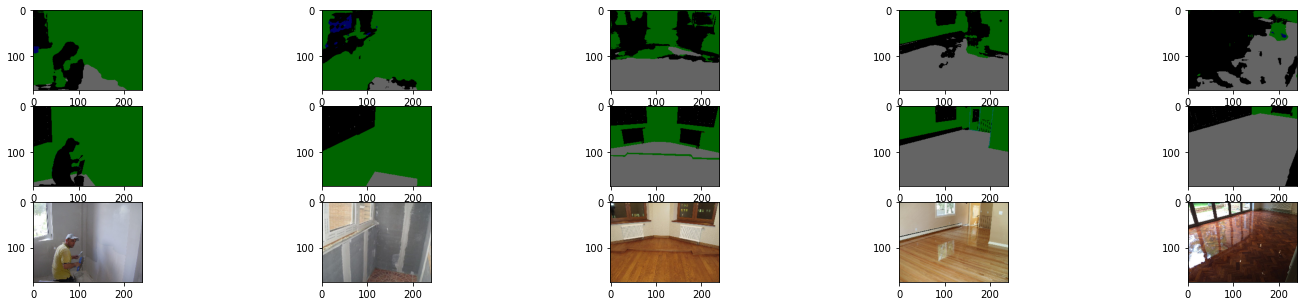

In [ ]:
processImage(modelM_relu, 5, num_classes)

**Итоги**: Самый плохой результат дала сеть при активации "softmax". При "elu" и "relu" результат очень близкий, возможно из-за того что сеть мало обучалась (всего 20 эпох). val_dice_coef у "elu" выше, что говорит о том что при дальнейшем дообучении подобная сеть может дать хороший результат.

### **Посмотрим на результаты работы сети с разным batch_size, на 20 эпохах, активационная функция = "relu"**

**batch_size=5**

In [ ]:
modelM_5 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM_5.fit(xTrain, yTrain, epochs=20, batch_size=5, validation_data = (xVal, yVal))

Epoch 1/20
180/180 [==============================] - 27s 151ms/step - loss: 1.0721 - dice_coef: 0.4580 - val_loss: 4.0744 - val_dice_coef: 0.4117
Epoch 2/20
180/180 [==============================] - 27s 149ms/step - loss: 0.8674 - dice_coef: 0.5433 - val_loss: 1.8586 - val_dice_coef: 0.4271
Epoch 3/20
180/180 [==============================] - 27s 149ms/step - loss: 0.7978 - dice_coef: 0.5867 - val_loss: 1.5655 - val_dice_coef: 0.3986
Epoch 4/20
180/180 [==============================] - 27s 149ms/step - loss: 0.7682 - dice_coef: 0.5978 - val_loss: 1.4198 - val_dice_coef: 0.4065
Epoch 5/20
180/180 [==============================] - 27s 149ms/step - loss: 0.7274 - dice_coef: 0.6229 - val_loss: 0.8341 - val_dice_coef: 0.5876
Epoch 6/20
180/180 [==============================] - 27s 149ms/step - loss: 0.7013 - dice_coef: 0.6376 - val_loss: 0.8250 - val_dice_coef: 0.5662
Epoch 7/20
180/180 [==============================] - 27s 149ms/step - loss: 0.6941 - dice_coef: 0.6426 - val_loss: 0.

In [ ]:
modelM_5.save_weights('/content/drive/My Drive/modelM_5.h5')

**batch_size=15**

In [ ]:
modelM_15 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM_15.fit(xTrain, yTrain, epochs=20, batch_size=15, validation_data = (xVal, yVal))

Epoch 1/20
60/60 [==============================] - 21s 348ms/step - loss: 1.0913 - dice_coef: 0.4573 - val_loss: 14.3413 - val_dice_coef: 0.0756
Epoch 2/20
60/60 [==============================] - 21s 346ms/step - loss: 0.8458 - dice_coef: 0.5567 - val_loss: 7.7970 - val_dice_coef: 0.3955
Epoch 3/20
60/60 [==============================] - 21s 345ms/step - loss: 0.7761 - dice_coef: 0.5952 - val_loss: 2.9558 - val_dice_coef: 0.4657
Epoch 4/20
60/60 [==============================] - 21s 346ms/step - loss: 0.7349 - dice_coef: 0.6174 - val_loss: 3.2380 - val_dice_coef: 0.4748
Epoch 5/20
60/60 [==============================] - 21s 346ms/step - loss: 0.6986 - dice_coef: 0.6349 - val_loss: 2.1242 - val_dice_coef: 0.4735
Epoch 6/20
60/60 [==============================] - 21s 346ms/step - loss: 0.6622 - dice_coef: 0.6558 - val_loss: 1.6273 - val_dice_coef: 0.5892
Epoch 7/20
60/60 [==============================] - 21s 345ms/step - loss: 0.6485 - dice_coef: 0.6639 - val_loss: 1.1064 - val_di

In [ ]:
modelM_15.save_weights('/content/drive/My Drive/modelM_15.h5')

**batch_size=25**

In [ ]:
modelM_25 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM_25.fit(xTrain, yTrain, epochs=20, batch_size=25, validation_data = (xVal, yVal))

Epoch 1/20
36/36 [==============================] - 21s 586ms/step - loss: 1.1717 - dice_coef: 0.4216 - val_loss: 11.5525 - val_dice_coef: 0.2822
Epoch 2/20
36/36 [==============================] - 21s 590ms/step - loss: 0.8776 - dice_coef: 0.5362 - val_loss: 8.4579 - val_dice_coef: 0.3282
Epoch 3/20
36/36 [==============================] - 21s 590ms/step - loss: 0.7853 - dice_coef: 0.5835 - val_loss: 5.0729 - val_dice_coef: 0.4464
Epoch 4/20
36/36 [==============================] - 21s 590ms/step - loss: 0.7372 - dice_coef: 0.6166 - val_loss: 5.7060 - val_dice_coef: 0.4340
Epoch 5/20
36/36 [==============================] - 21s 590ms/step - loss: 0.7010 - dice_coef: 0.6358 - val_loss: 4.8124 - val_dice_coef: 0.4469
Epoch 6/20
36/36 [==============================] - 21s 590ms/step - loss: 0.6831 - dice_coef: 0.6461 - val_loss: 4.9444 - val_dice_coef: 0.4477
Epoch 7/20
36/36 [==============================] - 21s 591ms/step - loss: 0.6658 - dice_coef: 0.6520 - val_loss: 3.0675 - val_di

In [ ]:
modelM_25.save_weights('/content/drive/My Drive/modelM_25.h5')

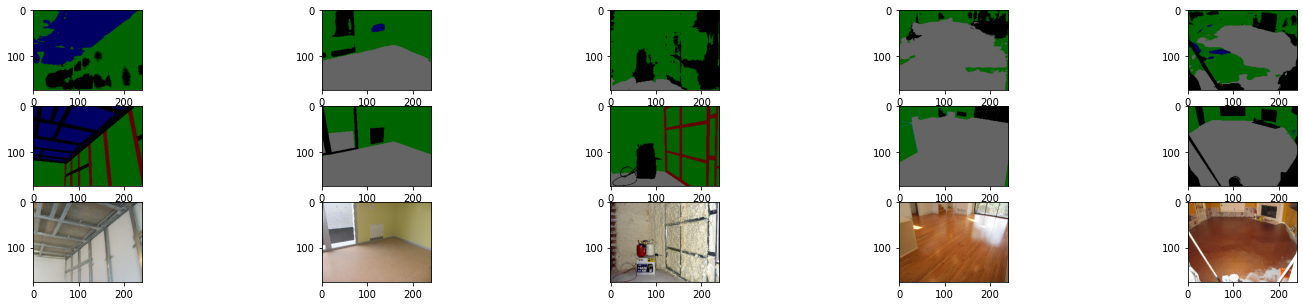

In [ ]:
processImage(modelM_5, 5, num_classes)

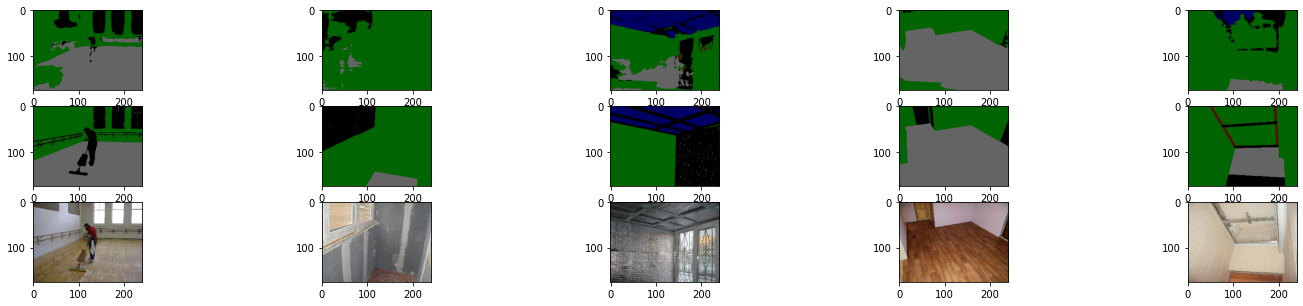

In [ ]:
processImage(modelM_15, 5, num_classes)

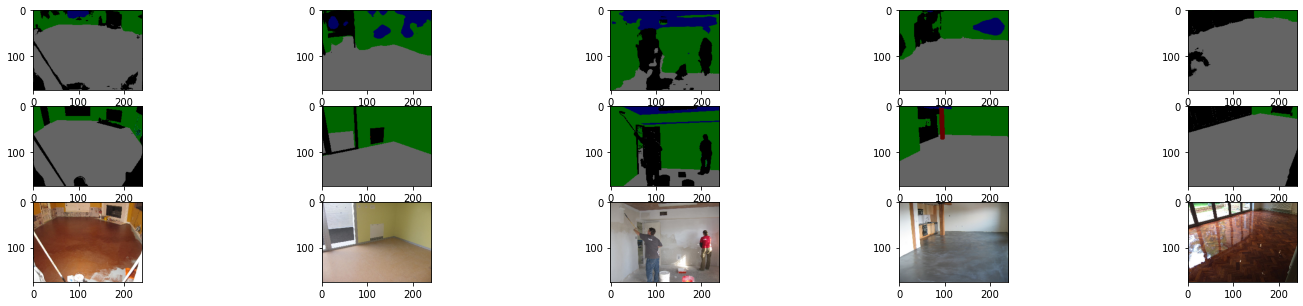

In [ ]:
processImage(modelM_25, 5, num_classes)

**Итоги:** к сожалению обучить удальсь только на 20 эпохах, поэтому результат плохенький у всех размеров batch_size, но если внимательно присмотрется самым оптимальным кажется batch_size=15, более четкие линии и распознавание.

### **Обший Итог:** 

**Лучшая архитектура:** Улучшенная и доработанная U-net с большим количесвом фильтров

**Оптимальный batch_size** = 15

**Активационная функция показавшая лучший результат** - "elu"


## **PRO**

### **Вариант 1**

**Задание:**
Напишите PSPNet для сегментации на базе стройки, добейтесь максимально возможной точности.


In [ ]:
'''
  Функция создания сети PSPNet
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def f_PSPNet(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                          
    x = Conv2D(1024, (3, 3), padding='same')(img_input) 
    x = BatchNormalization()(x)                                             
 
    exit1 = Activation('relu')(x)   
    
    # Block 1
    
    x = MaxPooling2D(16)(exit1)                         
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(x) 
    x = BatchNormalization()(x)                                         
    x = Activation('relu')(x)

    x = Conv2DTranspose(1024, (3, 3), strides=(16), padding='same')(x) 
    x = BatchNormalization()(x)                                         
                                  
    block_1_out = Activation('relu')(x)                                 
   

    # Block 2
    
    x2 = MaxPooling2D(8)(exit1)                     
    x2 = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x2) 
    x2 = BatchNormalization()(x2)  
    x2 = Activation('relu')(x2)

    x2 = Conv2DTranspose(1024, (3, 3), strides=(8), padding='same')(x2) 
    x2 = BatchNormalization()(x2)                                         
                                       
    block_2_out = Activation('relu')(x2)    


    # Block 3
    
    x3 = MaxPooling2D(4)(exit1)                        
    x3 = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x3) 
    x3 = BatchNormalization()(x3)  
    x3 = Activation('relu')(x3)

    x3 = Conv2DTranspose(1024, (3, 3), strides=(4), padding='same')(x3) 
    x3 = BatchNormalization()(x3)                                         
                                       
    block_3_out = Activation('relu')(x3)  


    # Block 4
    
    x4 = MaxPooling2D(2)(exit1)                          
    x4 = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x4) 
    x4 = BatchNormalization()(x4)  
    x4 = Activation('relu')(x4)

    x4 = Conv2DTranspose(1024, (3, 3), strides=(2), padding='same')(x4) 
    x4 = BatchNormalization()(x4)                                         
                                       
    block_4_out = Activation('relu')(x4)

    
    y = concatenate([block_1_out, block_2_out, block_3_out, block_4_out])
    y1 = concatenate([exit1, y])
    y2 = Conv2D(64, (3, 3), padding='same')(y1) 
    y2 = BatchNormalization()(y2)  
    y2 = Activation('relu')(y2)
   
    ex = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(y2) 

    model = Model(img_input, ex)                                             

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

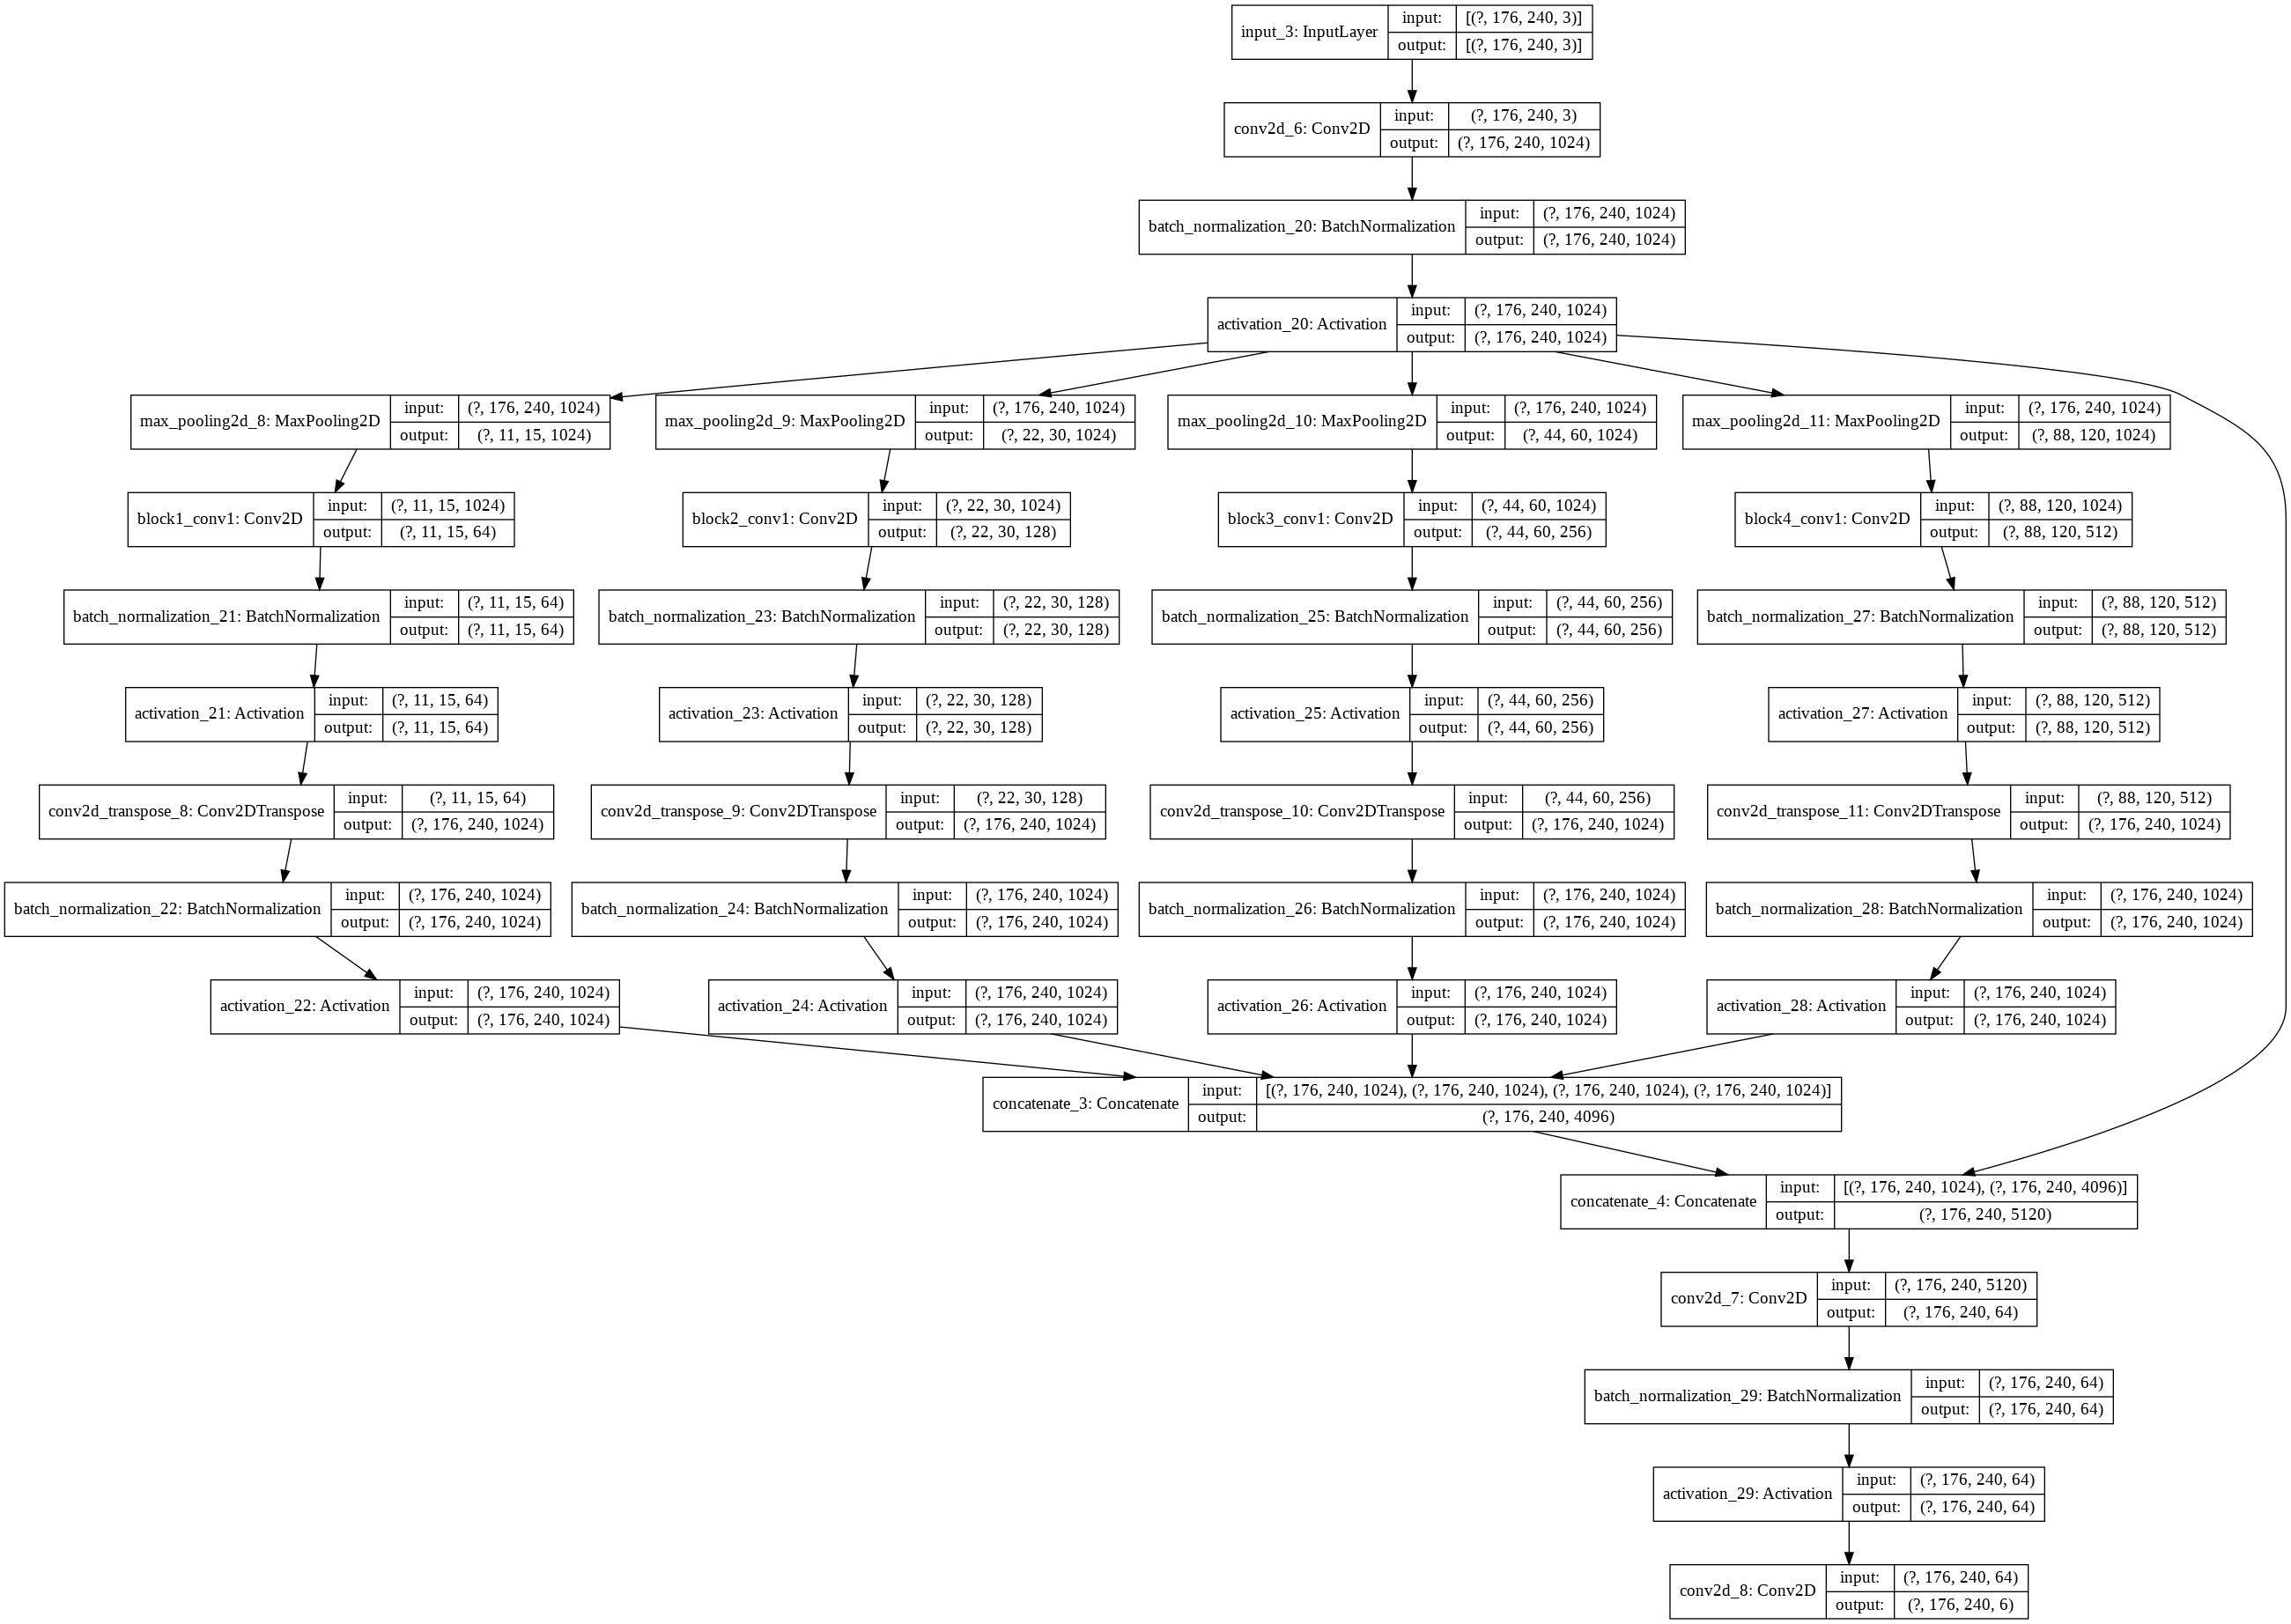

In [ ]:
from tensorflow.keras.utils import plot_model
modelM_PSPNet_50 = f_PSPNet(num_classes, (img_width, img_height,3))
plot_model(modelM_PSPNet_50, to_file='modelM_PSPNet_50.png', show_shapes=True)

In [ ]:
history = modelM_PSPNet_50.fit(xTrain, yTrain, epochs=50, batch_size=2, validation_data = (xVal, yVal))

Epoch 1/50
450/450 [==============================] - 176s 391ms/step - loss: 0.9959 - dice_coef: 0.4816 - val_loss: 1.3837 - val_dice_coef: 0.3366
Epoch 2/50
450/450 [==============================] - 176s 391ms/step - loss: 0.9743 - dice_coef: 0.4928 - val_loss: 1.2020 - val_dice_coef: 0.3739
Epoch 3/50
450/450 [==============================] - 176s 391ms/step - loss: 0.9575 - dice_coef: 0.5017 - val_loss: 1.0760 - val_dice_coef: 0.4128
Epoch 4/50
450/450 [==============================] - 176s 391ms/step - loss: 0.9436 - dice_coef: 0.5079 - val_loss: 1.1019 - val_dice_coef: 0.4499
Epoch 5/50
450/450 [==============================] - 176s 391ms/step - loss: 0.9317 - dice_coef: 0.5119 - val_loss: 1.1890 - val_dice_coef: 0.4391
Epoch 6/50
450/450 [==============================] - 176s 391ms/step - loss: 0.9165 - dice_coef: 0.5210 - val_loss: 1.1055 - val_dice_coef: 0.4244
Epoch 7/50
450/450 [==============================] - 176s 391ms/step - loss: 0.8980 - dice_coef: 0.5295 - val_l

In [ ]:
modelM_PSPNet_50.save_weights('/content/drive/My Drive/modelM_PSPNet_50.h5')

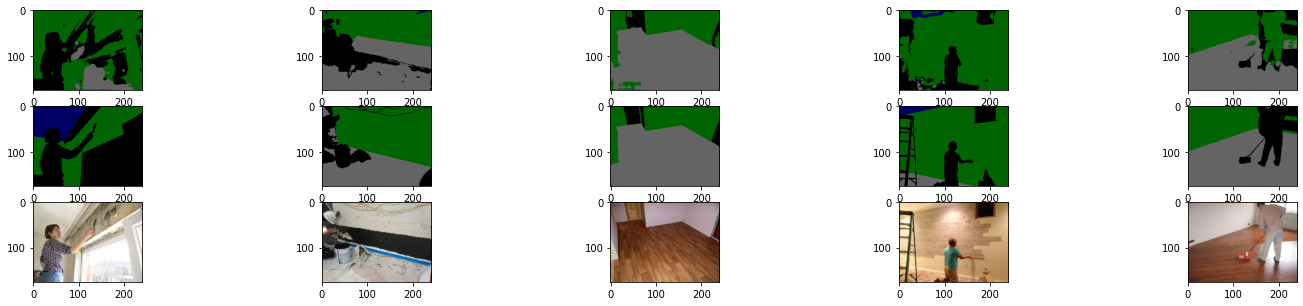

In [ ]:
processImage(modelM_PSPNet_50, 5, num_classes)

Итоги: dice_coef не высокий, но качество сегментированных изображений получилось вполне приемлимым. Если улучшать сеть, добавлять слои и увеличивать количество нейронов, возможно дольше обучать можно добиться еще лучшего результата.  